## Imports 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pickle import dump,load
import torch
from collections import OrderedDict
import torch
import torch.nn as nn

/Users/harrysullivan/anaconda3/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [52]:
torch.backends.mps.is_available()

False

## Helpful Functions

In [2]:
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

## Basic Unet Architecture

In [48]:
class UNet(nn.Module):

    def __init__(self, in_channels=3, out_channels=1, init_features=32):
        super(UNet, self).__init__()

        features = init_features
        self.encoder1 = UNet._block(in_channels, features, name="enc1")
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.encoder2 = UNet._block(features, features * 2, name="enc2")
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.encoder3 = UNet._block(features * 2, features * 4, name="enc3")
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.encoder4 = UNet._block(features * 4, features * 8, name="enc4")
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.bottleneck = UNet._block(features * 8, features * 16, name="bottleneck")

        self.upconv4 = nn.ConvTranspose2d(
            features * 16, features * 8, kernel_size=2, stride=2
        )
        self.decoder4 = UNet._block((features * 8) * 2, features * 8, name="dec4")
        self.upconv3 = nn.ConvTranspose2d(
            features * 8, features * 4, kernel_size=2, stride=2
        )
        self.decoder3 = UNet._block((features * 4) * 2, features * 4, name="dec3")
        self.upconv2 = nn.ConvTranspose2d(
            features * 4, features * 2, kernel_size=2, stride=2
        )
        self.decoder2 = UNet._block((features * 2) * 2, features * 2, name="dec2")
        self.upconv1 = nn.ConvTranspose2d(
            features * 2, features, kernel_size=2, stride=2
        )
        self.decoder1 = UNet._block(features * 2, features, name="dec1")

        self.conv = nn.Conv2d(
            in_channels=features, out_channels=out_channels, kernel_size=1
        )

    def forward(self, x):
#         print("Size of input:")
#         print(x.size())
#         print()
        enc1 = self.encoder1(x)
#         print("Size of Enc1 output:")
#         print(enc1.size())
#         print()
        enc2 = self.encoder2(self.pool1(enc1))
#         print("Size of Enc2 output:")
#         print(enc2.size())
#         print()
        enc3 = self.encoder3(self.pool2(enc2))
#         print("Size of Enc3 output:")
#         print(enc3.size())
#         print()
        enc4 = self.encoder4(self.pool3(enc3))
#         print("Size of Enc4 output:")
#         print(enc4.size())
#         print()

        bottleneck = self.bottleneck(self.pool4(enc4))
        
#         print("Size of Bottleneck output:")
#         print(bottleneck.size())
#         print()

        dec4 = self.upconv4(bottleneck)    
        dec4 = torch.cat((dec4, enc4), dim=1)
        dec4 = self.decoder4(dec4)
        
#         print("Size of dec4 output:")
#         print(dec4.size())
#         print()
        
        dec3 = self.upconv3(dec4)
        
#         print("Size of dec3 input pre cat:")
#         print(dec3.size())
#         print()
        
        dec3 = torch.cat((dec3, enc3), dim=1)
        
#         print("Size of dec3 input post cat:")
#         print(dec3.size())
#         print()
        
        dec3 = self.decoder3(dec3)
        
#         print("Size of dec3 output:")
#         print(dec3.size())
#         print()
        
        dec2 = self.upconv2(dec3)
        dec2 = torch.cat((dec2, enc2), dim=1)
        dec2 = self.decoder2(dec2)
        
#         print("Size of dec2 output:")
#         print(dec2.size())
#         print()
        
        dec1 = self.upconv1(dec2)
        dec1 = torch.cat((dec1, enc1), dim=1)
        dec1 = self.decoder1(dec1)
        
#         print("Size of dec1 output:")
#         print(dec1.size())
#         print()
        
        return torch.sigmoid(self.conv(dec1))

    @staticmethod
    def _block(in_channels, features, name):
        return nn.Sequential(
            OrderedDict(
                [
                    (
                        name + "conv1",
                        nn.Conv2d(
                            in_channels=in_channels,
                            out_channels=features,
                            kernel_size=3,
                            padding=1,
                            bias=False,
                        ),
                    ),
                    (name + "norm1", nn.BatchNorm2d(num_features=features)),
                    (name + "relu1", nn.ReLU(inplace=True)),
                    (
                        name + "conv2",
                        nn.Conv2d(
                            in_channels=features,
                            out_channels=features,
                            kernel_size=3,
                            padding=1,
                            bias=False,
                        ),
                    ),
                    (name + "norm2", nn.BatchNorm2d(num_features=features)),
                    (name + "relu2", nn.ReLU(inplace=True)),
                ]
            )
        )

## Reading in Data

In [49]:
batch_raw = unpickle('cifar-10-batches-py/data_batch_1')

batch = dict()
for key in batch_raw.keys():
    batch[str(key)[2:-1]] = batch_raw[key]

idx = 0
    
r = batch['data'][idx][:1024].reshape((32,32))
g = batch['data'][idx][1024:1024*2].reshape((32,32))
b = batch['data'][idx][1024*2:1024*3].reshape((32,32))

image = torch.zeros((32,32,3))
image[:,:,0] = torch.from_numpy(r)
image[:,:,1] = torch.from_numpy(g)
image[:,:,2] = torch.from_numpy(b)

## A Single Forward Pass Through a U-net

Size of input:
torch.Size([1, 3, 32, 32])

Size of Enc1 output:
torch.Size([1, 32, 32, 32])

Size of Enc2 output:
torch.Size([1, 64, 16, 16])

Size of Enc3 output:
torch.Size([1, 128, 8, 8])

Size of Enc4 output:
torch.Size([1, 256, 4, 4])

Size of Bottleneck output:
torch.Size([1, 512, 2, 2])

Size of dec4 output:
torch.Size([1, 256, 4, 4])

Size of dec3 input pre cat:
torch.Size([1, 128, 8, 8])

Size of dec3 input post cat:
torch.Size([1, 256, 8, 8])

Size of dec3 output:
torch.Size([1, 128, 8, 8])

Size of dec2 output:
torch.Size([1, 64, 16, 16])

Size of dec1 output:
torch.Size([1, 32, 32, 32])

Size of output:
torch.Size([1, 1, 32, 32])


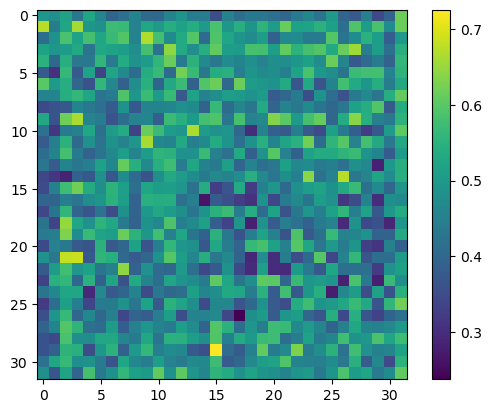

In [50]:
net = UNet()

out = net.forward(image.reshape(1,3,32,32))

print("Size of output:")
print(out.size())

plt.imshow(out.reshape(32,32).detach().numpy())
plt.colorbar()
plt.show()


In [53]:
net(image.reshape(1,3,32,32))

Size of input:
torch.Size([1, 3, 32, 32])

Size of Enc1 output:
torch.Size([1, 32, 32, 32])

Size of Enc2 output:
torch.Size([1, 64, 16, 16])

Size of Enc3 output:
torch.Size([1, 128, 8, 8])

Size of Enc4 output:
torch.Size([1, 256, 4, 4])

Size of Bottleneck output:
torch.Size([1, 512, 2, 2])

Size of dec4 output:
torch.Size([1, 256, 4, 4])

Size of dec3 input pre cat:
torch.Size([1, 128, 8, 8])

Size of dec3 input post cat:
torch.Size([1, 256, 8, 8])

Size of dec3 output:
torch.Size([1, 128, 8, 8])

Size of dec2 output:
torch.Size([1, 64, 16, 16])

Size of dec1 output:
torch.Size([1, 32, 32, 32])



tensor([[[[0.4940, 0.4773, 0.5187,  ..., 0.3459, 0.3935, 0.6164],
          [0.6728, 0.4444, 0.5272,  ..., 0.5856, 0.4750, 0.6168],
          [0.4145, 0.4874, 0.5851,  ..., 0.5112, 0.3838, 0.4993],
          ...,
          [0.3605, 0.3890, 0.5540,  ..., 0.4530, 0.4595, 0.5215],
          [0.4210, 0.5271, 0.5651,  ..., 0.4638, 0.3507, 0.5532],
          [0.4825, 0.3686, 0.5225,  ..., 0.4402, 0.4742, 0.6072]]]],
       grad_fn=<SigmoidBackward0>)